# Data Sources and Files

We use the following data sources and/or files:
 1) "reverse_loc.pickle": a .PICKLE file with the reversed-coordinates (*i.e.*, the name of the parish, city and district related to a given pair of coordinates)
 
 2) "df_reverse_coords.csv": a .CSV file with the reversed-coordinates (*i.e.*, the name of the parish, city and district related to a given pair of coordinates)

# Introduction

## What is the problem?
As stated by the challenge provider in the official document, "*cities are flooded by countless outdoor advertising panels, often with a poor distribution*". Hence, we acknowledge that these visual aspects are crucial in the urban planning process since each plan choice can generate obstruction of urban elements, thus producing adverse effects on the city’s image.

## How do we relate this problem with the United Nations' Sustainable Development Goals (SDGs)?
Once again, we started by looking at the official document given by the challenge provider, which establishes a connection between this challenge and the **11th UN Sustainable Goal - Sustainable Cities and Communities**. From an attentive look at the scope of this 11th SDG, we can conclude that this is, somehow, related to the topic of "*Sustainable cities and human settlements*" (please refer to [https://sdgs.un.org/topics/sustainable-cities-and-human-settlements](https://sdgs.un.org/topics/sustainable-cities-and-human-settlements)). Since it is expected that the number of people in cities will grow significantly by 2050, it is of utmost importance that policy- and decision-makers define a sustainable strategy to assure that their cities have the right infrastructures to keep up with this development rate. We highlight two important ideas:
 - *Improving human settlements management*; 
 - *Promoting sustainable land-use planning and management*.

The ideas above are directly related to the proper organisation of outdoor advertising panels in cities in the sense that careful management may contribute to an increase of visual quality of streets and roads but also allows to increase the focus on the message and the announcement that the panel intends to transmit. Therefore, we agree that reducing the outdoor advertising visual impact in cities will contribute to minimising the reduction of the audience of the outdoor ad sector, thus improving the visual environment of cities and the sustainability of outdoor advertising activity.


## How do we propose to solve this problem?
We developed a metaheuristics-based algorithm (local/neighbourhood search) that optimises the outdoor-billboard density (*i.e.*, the number of outdoor billboards in a given radius). We start by creating neighbour solutions through swap operations in which we change the coordinates of a given billboard and assess the impact on hour fitness function, which takes this variable into account. In the end, we are capable of proposing an alternative layout for the billboard location without needing to remove billboards. Why did we not want to remove billboards? Well, we do not know if by removing a billboard we are jeopardising the business of a given company. Therefore, we tried to keep our problem approach as simples as possible and thinking about the stakeholders as well.

# Development

In [3]:
# !pip install pyshp
import pandas as pd
import pickle
from scipy.spatial import cKDTree
import numpy as np
import shapefile
from geopy import distance
from folium.plugins import FastMarkerCluster
import folium
import branca.colormap as cm 
from collections import defaultdict
from folium.plugins import HeatMap
from geopy.distance import vincenty

KMS_PER_RADIAN = 6371.0088

In [4]:
def read_shapefile(shp_path):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' column holding
    the geometry information. This uses the pyshp package
    """

    #read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write into a dataframe
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)

    return df

In [5]:
# Read shapefile with the ourdoor inventory

df = read_shapefile('data/outdoor_inventory/Outdoor_Inventory_AV.shp')

# Read pickle file containing mapping between coordinates and location (done in appendix)
reverse_coords_list = pd.read_pickle('data/reverse_loc.pickle')


# Map metadata regarding location
df['address_road'] = [x.get('address').get('road') for x in reverse_coords_list]
df['concelho'] = [x.get('address').get('town') for x in reverse_coords_list]
df['freguesia'] = [x.get('address').get('village') if 'village' in x.get('address') else x.get('address').get('neighbourhood') for x in reverse_coords_list]
df['distrito'] = [x.get('address').get('county') for x in reverse_coords_list]

# Determine if location is national road, highway or city center
df['address_road'] = df['address_road'].fillna('')
df['is_national_road'] = df['address_road'].str.contains('EN')
df['is_highway'] = df['address_road'].str.contains('Auto')
df['is_city_center'] = (~df['is_national_road']) & (~df['is_highway']) & (df['address_road'] != '')

Mounted at /content/drive


In [6]:
df.head(3)

PanelID         X          Y  ...  is_national_road  is_highway is_city_center
0    26144 -8.473975  40.900768  ...             False       False           True
1    11714 -9.315949  38.958125  ...              True       False          False
2    26109 -8.510079  40.871821  ...             False       False           True

[3 rows x 13 columns]

## Exploratory Data Analysis

The next cells present you an exploratory data analysis to give you some insights and/or intuition on the information we extracted before going into a "very algorithmic" approach.

In [7]:
def find_neighbours_within_radius(xy, radius):
    """
    This function is used for returning the list of neighbours within a certain radius in a very efficient way.
    Inspirations: 
    
    # https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
    # https://stackoverflow.com/questions/43592094/efficient-way-to-calculate-geographic-density-in-pandas 
    # https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data 
    
    For instance, between the coordinates (40.900768, -8.473975) and (40.214686, -8.432738) everything is counted as being within a 1.5km
        radius. The actual distance between them is 600m, determined using geopy.distance, not shown here.
    """
    tree = cKDTree(xy)
    within_radius = tree.query_ball_tree(tree, r=radius)
    return within_radius

def get_density_billboards(df, radius=1.5):
    """
    Calculate number of billboards in a X km radius for each point
    """
    
    df_copy = df.copy()

    neighbours_within_radius = find_neighbours_within_radius(
        np.radians(df_copy[['Y', 'X']].values), 
        radius/KMS_PER_RADIAN
    )

    df_copy['nbr_points_around_billboard'] = [len(x) for x in neighbours_within_radius]

    return df_copy, neighbours_within_radius

In [8]:
df, neighbours_within_radius = get_density_billboards(df)

In [9]:
df['average_people_around_billboard'] = [np.mean(df.iloc[x].Average_Da) for x in neighbours_within_radius]
df['std_people_around_billboard'] = [np.std(df.iloc[x].Average_Da) for x in neighbours_within_radius]

# points where this value is very negative are just visual noise, they make no impact
# retirar N billboards por concelho
df['diff_to_neighbourhood'] = df['Average_Da'] - df['average_people_around_billboard']

# sitios maus: sitios com pouca gente, e que tens muita gente a volta. As pessoas estão a passar pelos outros, e não pelo teu. 
# zonas com muita densidade: estamos a dividir a eficiencia de marketing com outras empresas

# Locais para novos billboards?

In [10]:
all_coordinates = df[['Y', 'X']].values

In [11]:
n_out=df[["X", "Y"]].value_counts().to_frame('n_OutdoorAd').reset_index()

m = folium.Map(location=[38.760398,-9.190202], zoom_start=10)

steps = 10
color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)


heatmap = HeatMap(
    list(zip(n_out["Y"],n_out["X"], n_out["n_OutdoorAd"])), gradient = gradient_map, radius=7)

color_map.add_to(m)
heatmap.add_to(m)

m

#The center of Lisbon, Porto and Faro are the areas where there are more billbords in the same coordinate (latitude, longitude). 

In [12]:
m = folium.Map(location=[38.760398,-9.190202], zoom_start=10)

FastMarkerCluster(df[['Y', 'X']].values).add_to(m)

m

In [13]:
mean_Average_Da = df.groupby(['X', 'Y']).agg({'Average_Da': 'mean'}).reset_index()

m1 = folium.Map(location=[38.760398,-9.190202], zoom_start=10)

heatmap = HeatMap(
    list(zip(mean_Average_Da["Y"],mean_Average_Da["X"], mean_Average_Da["Average_Da"])), gradient = gradient_map, radius=7)

color_map.add_to(m1)
heatmap.add_to(m1)

m1

## Metaheuristics: Billboard optimization

We now present you the algorithmic approach used to optimise the outdoor billboard. We start by defining our fitness function $f = den(s)$, where $den(s)$ is the density of outdoor billboard in a given radius. In this case, our goal is to minimise this function.

In [14]:
# Focus on lisbon

df_subset = df[df['distrito'] == 'Lisboa'].reset_index()

# We might have different impressions for the same coordinate (maybe diff directions of traffic?) so let's average it out

MEAN_IMPRESSIONS_PER_COORD = df_subset.groupby(['X', 'Y']).agg(
    {'freguesia': 'first',
     'distrito': 'first',
     'concelho': 'first',
     'Average_Da': 'mean'}).reset_index()

df_subset = df_subset[['PanelID', 'X', 'Y', 'Max_Visibi', 'Average_Da']]

MEAN_IMPRESSIONS_PER_COORD.head(2)

X          Y    freguesia distrito concelho  Average_Da
0 -9.475810  38.815709      Colares   Lisboa     None       339.0
1 -9.470378  38.736197  Alcabideche   Lisboa     None      2285.0

In [15]:
def fitness(df):
    """
    Fitness function, which we want to minimize
    """
    
    # Get billboard density
    df, _ = get_density_billboards(df)

    max_density = df['nbr_points_around_billboard'].mean()
    total_number_of_views = df['Average_Da'].sum()
    return max_density # + total_number_of_views

fitness(df_subset)

382.6084085051546

In [16]:
def get_neighbours(df, nbr_neighbours):
    """
    Creates a list of size nbr_neighbours with potential swaps of coordinates.
    
    It first picks random samples from MEAN_IMPRESSIONS_PER_COORD, random positions in df and allocates those values.
    """
    
    neighbors = []
    
    # Pick new positions for swapping random elements of df
    sampled_coords = MEAN_IMPRESSIONS_PER_COORD.sample(nbr_neighbours).reset_index()
    
    for i in range(nbr_neighbours):
        
        df_copy = df.copy()

        # Pick a random number between 0 and len(df)
        random_number = np.random.randint(0, len(df_copy))
                    
        # Replace by the Average_Da at that position
        df_copy.loc[random_number, ['X', 'Y', 'Average_Da']] = sampled_coords.loc[i, ['X', 'Y', 'Average_Da']]
                
        neighbors.append(df_copy)
    
    return neighbors

In [17]:
def shuffle_perturbation(neighbor, prob=0.1):
    """
    Randomly shuffles a subset of positions in the generated neighbors.
    
    It picks a neighbor and generates a new neighbour with some of its positions shuffled according to a given probability.
    """
    
    # Create a copy of the neighbor
    neighbor_copy = neighbor.copy()
    
    # Get the length of this neighbor
    neighbor_len = len(MEAN_IMPRESSIONS_PER_COORD)
    
    # Create a mask of the positions that will shuffle
    mask = np.random.random_sample((neighbor_len,)) <= prob
    mask = np.arange(neighbor_len)[mask]
    
    # Create a shuffled mask to change within these values
    shuffled_mask = mask.copy()
    
    # Shuffle this mask
    np.random.shuffle(shuffled_mask)
    
    # Create a variable with the coords that will be used to substitute
    final_coords = MEAN_IMPRESSIONS_PER_COORD.loc[shuffled_mask]

    # Perform the shuffle operation
    neighbor_copy.loc[mask, ['X', 'Y', 'Average_Da']] = final_coords[['X', 'Y', 'Average_Da']].values   

    return neighbor_copy

In [18]:
def shuffle_perturbation_with_probs(neighbor, subset_size_perc=0.1):
    """
    Shuffles a subset of positions in the generated neighbors according to a given probability, which is given by their density.
    
    It picks a neighbor and generates a new neighbour with some of its positions shuffled.
    """
    
    # Create a copy of the neighbor
    neighbor_copy = neighbor.copy()
    
    # Get the length of this neighbor
    neighbor_len = len(MEAN_IMPRESSIONS_PER_COORD)
    
    
    # The mask  of positions to shuffle is not random
    # We will create a mask with probabilities according to density
    _MEAN_IMPRESSIONS_PER_COORD = MEAN_IMPRESSIONS_PER_COORD.copy()
    _MEAN_IMPRESSIONS_PER_COORD["probs"] = _MEAN_IMPRESSIONS_PER_COORD["Average_Da"] / _MEAN_IMPRESSIONS_PER_COORD["Average_Da"].sum()
    
    # Create a list with indices
    indices = [i for i in range(neighbor_len)]
    # print(len(indices), neighbor_len)
    mask = np.random.choice(indices, size=int(subset_size_perc * neighbor_len), replace=True, p=_MEAN_IMPRESSIONS_PER_COORD["probs"].values)
    
    # Shuffle this mask
    shuffled_mask = mask.copy()
    
    # Shuffle this mask
    np.random.shuffle(shuffled_mask)
    
    
    # Create a variable with the coords that will be used to substitute
    final_coords = MEAN_IMPRESSIONS_PER_COORD.loc[shuffled_mask]

    # Perform the shuffle operation
    neighbor_copy.loc[mask, ['X', 'Y']] = final_coords[['X', 'Y']].values
    
    
    return neighbor_copy

### Apply perturbations on the initial solution for a set of iterations

In [19]:
best_fitness = np.inf
best_solution = df_subset

history_of_best_solutions = []

for iteration in range(10):
    
    # Get n random neighbours
    neighbors = best_solution
    
    # Probability of shuffle perturbation
    proba = np.random.randint(2)
    print(proba)
    if proba == 1:
        neighbors = shuffle_perturbation(neighbors, 0.1) #get_neighbours(best_solution, 5)
    
    
    # Probability of balanced perturbation
    proba = np.random.randint(2)
    print(proba)
    if proba == 1:
        neighbors = shuffle_perturbation_with_probs(neighbors, 0.1)
    
    
    # Convert to list
    neighbors = [neighbors]
    
    # Get 5 more shuffled neighbours and append to these neighbors list
    #for n in neighbors:
    #    neighbors.append(shuffle_perturbation(n))
    
    # Sanity-check print
    print(f"Nr of possible solutions: {len(neighbors)}.")
    
    # Get fitnesses of possible solutions
    fitness_neighbours = [fitness(x) for x in neighbors]
    
    neighbour_lower_fitness_idx = np.argmin(fitness_neighbours)
    fitness_neighbour_lower_fitness = fitness_neighbours[neighbour_lower_fitness_idx]
    neighbour_lower_fitness = neighbors[neighbour_lower_fitness_idx]
    
    if fitness_neighbour_lower_fitness < best_fitness:
        best_fitness = fitness_neighbour_lower_fitness
        best_solution = neighbour_lower_fitness
        
        history_of_best_solutions.append(best_solution)

        print("Found a better solution!")
        
    print("Epoch %d | Fitness %f" % (iteration, best_fitness))

0
1
Nr of possible solutions: 1.
Found a better solution!
Epoch 0 | Fitness 389.129349
1
1
Nr of possible solutions: 1.
Epoch 1 | Fitness 389.129349
0
1
Nr of possible solutions: 1.
Epoch 2 | Fitness 389.129349
0
0
Nr of possible solutions: 1.
Epoch 3 | Fitness 389.129349
0
1
Nr of possible solutions: 1.
Epoch 4 | Fitness 389.129349
1
0
Nr of possible solutions: 1.
Epoch 5 | Fitness 389.129349
1
1
Nr of possible solutions: 1.
Epoch 6 | Fitness 389.129349
0
0
Nr of possible solutions: 1.
Epoch 7 | Fitness 389.129349
1
0
Nr of possible solutions: 1.
Epoch 8 | Fitness 389.129349
0
1
Nr of possible solutions: 1.
Epoch 9 | Fitness 389.129349


In [20]:
best_solution.copy()

PanelID         X          Y  Max_Visibi  Average_Da
0        11714 -9.315949  38.958125          69        31.0
1        34634 -9.143221  38.710728          63        34.0
2         4660 -9.420993  38.702024          69        35.0
3        26319 -9.216405  38.780154          69        35.0
4        26317 -9.216424  38.780164          69        36.0
...        ...       ...        ...         ...         ...
12411     8110 -9.157572  38.705383         145     60496.0
12412     4671 -9.415045  38.701264         145     71045.0
12413     4676 -9.415113  38.701244         145     73035.0
12414    32007 -9.171094  38.703705         180     76575.0
12415    29984 -9.165918  38.750425         180     79714.0

[12416 rows x 5 columns]

Check changes

In [21]:
COLS = ['PanelID', 'X', 'Y', 'Max_Visibi']

In [22]:
df.shape

(30375, 17)

In [23]:
diff_solutions = df[COLS].merge(best_solution[COLS], on=['PanelID'], suffixes=(('', '_new')))
diff_solutions = diff_solutions[
    (diff_solutions['X'] != diff_solutions['X_new']) & (diff_solutions['Y'] != diff_solutions['Y_new'])
]

In [24]:
diff_solutions = diff_solutions.merge(MEAN_IMPRESSIONS_PER_COORD[['freguesia', 'concelho', 'distrito', 'X', 'Y']], on=['X', 'Y'], how='left')

In [25]:
diff_solutions = diff_solutions.merge(
    MEAN_IMPRESSIONS_PER_COORD[['freguesia', 'concelho', 'distrito', 'X', 'Y']], 
    left_on=['X_new', 'Y_new'],
    right_on=['X', 'Y'],
    how='left',
    suffixes=(('', '_new'))
)
diff_solutions = diff_solutions.loc[:,~diff_solutions.columns.duplicated()]


In [26]:
diff_solutions.head(2)

PanelID         X          Y  ...  freguesia_new  concelho_new  distrito_new
0     5836 -9.096992  38.774788  ...           None          None        Lisboa
1    27111 -9.301427  38.871958  ...   Rio de Mouro          None        Lisboa

[2 rows x 13 columns]

In [28]:
diff_solutions = diff_solutions.fillna('')

In [41]:
def distance_calc (row):
    start = (row['Y'], row['X'])
    stop = (row['Y_new'], row['X_new'])

    return vincenty(start, stop).kilometers


diff_solutions['distance_km'] = diff_solutions.apply (lambda row: distance_calc (row),axis=1)

#IDA E VOLTA
diff_solutions['distance_km_2x']=diff_solutions['distance_km']*2

#Considering that the average fuel consumption of a passenger car is equal to 5.8 liters/100 km (source: https://zero.ong/automoveis-conheca-as-diferencas-entre-consumos-anunciados-e-reais/)
#and that the price of gasoline is equal to 1.598 euros/liter (data from 24-May-2021, source: https://pt.globalpetrolprices.com/Portugal/gasoline_prices/), 
#we can then calculate an estimate of the money spent on billboard transportation
diff_solutions['travel_cost_euros']=diff_solutions['distance_km_2x']*0.058*1.598


#############################################################TO DO########################################################################
#Otimizar em relação à visibilidade. 
#Fazer estudo do dinheiro investido (euros)/(Average_Da_new-Average_Da)

PanelID         X  ...  travel_cost  travel_cost_euros
0        5836 -9.096992  ...     0.978213           0.978213
1       27111 -9.301427  ...     2.011480           2.011480
2       23767 -9.176292  ...     2.774208           2.774208
3       32071 -9.234222  ...     0.990128           0.990128
4       25081 -9.113719  ...     1.726308           1.726308
...       ...       ...  ...          ...                ...
1071    29219 -9.151951  ...     0.194701           0.194701
1072    19728 -9.256067  ...     6.732374           6.732374
1073     8936 -9.149371  ...     0.924866           0.924866
1074    19734 -9.260167  ...     6.758265           6.758265
1075    18006 -9.250548  ...     1.853824           1.853824

[1076 rows x 19 columns]

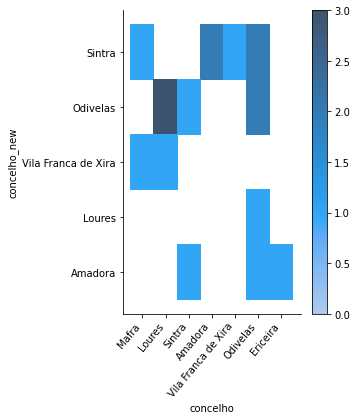

In [ ]:
import seaborn as sns

mask = (~diff_solutions.concelho.isna()) & (~diff_solutions.concelho_new.isna())
g = sns.displot(diff_solutions[mask], x="concelho", y="concelho_new", cbar=True)
g.set_xticklabels(rotation=50, ha='right')

In [ ]:
# Ao trocar da posição (x1, y1) para (x2, y2) estou a ganhar X de audiencia
# O custo médio de aluguer é X€ , mantém se fixo
# assumindo y% das pessoas que vêm têm interesse na marca, estamos a ter um impacto K vezes ... 

In [ ]:
coords = []

for i, row in diff_solutions.iterrows():
    coords.append(
    [(row['Y'], row['X']), (row['Y_new'], row['X_new'])])

In [ ]:
m = folium.plugins.DualMap(location=[38.760398,-9.190202], zoom_start=10)

FastMarkerCluster(df_subset[['Y', 'X']].values).add_to(m.m1)
FastMarkerCluster(best_solution[['Y', 'X']].values).add_to(m.m2)

#m = plugins.DualMap(location=(52.1, 5.1), tiles=None, zoom_start=8)

m

# Conclusion

## Scalability and Impact

In 2017, advertising investments made in outdoor represented 11.7% of the market according to Omnicom data (source: https://obercom.pt/wp-content/uploads/2019/05/Publicidade_2019_Final.pdf). This percentage is mostly due to the knowledge of the advantages of this type of advertising, such as the great effectiveness in reach (it is a form of advertising without interruption since it remains on display 24 hours a day) and the power to reach different parts of the city, social classes and age groups (source: https://www.adquick.com/blog/what-are-the-benefits-of-outdoor-advertising/).

A recent study by the company PSE shows that the outdoor advertising medium has close to 90% coverage. With the new confinement decreed in January, both coverage and frequency have naturally decreased, resulting in a lower audience production. However, this audience is still high, around 50,000 viewers (source: https://www.meiosepublicidade.pt/2021/02/estudo-audiencias-outdoor-ja-mede-80-cento-dos-suportes-portugal/).

The annual corporate outdoor advertising media cost was in 2019, equal to €89 534 (source: https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0006846&contexto=bd&selTab=tab2&xlang=PT). By switching the position of billboards to positions with lower billboard density and higher visibility, we gain X% of audience. Considering that the average rental cost remains fixed, and assuming that Y people who see it have an interest in the brand, there is an impact K times greater.

## Future Work

It would be interesting to have information related to:

Distribution of the billboards per company (the concession): with this data we could optimise our algorithm by taking into account the distribution of billboards in a given radius per company.

Actual billboard coverage in the dataset